# Custom CNN with Genetic Algorithm Optimization

CUDA GPU detected and configured
Executing Cell 1: Balance Dataset
Balancing dataset...
Class Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images found
Augmenting Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot to reach 1000 images...
Generated 100 augmented images for Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Generated 200 augmented images for Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Generated 300 augmented images for Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Generated 400 augmented images for Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Class Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: Total 1000 images after balancing
Class Corn_(maize)___Common_rust_: 1192 images found
Class Corn_(maize)___Common_rust_: Total 1000 images after balancing
Class Corn_(maize)___Northern_Leaf_Blight: 985 images found
Augmenting Corn_(maize)___Northern_Leaf_Blight to reach 1000 images...
Class Corn_(maize)___Northern_Leaf_Blight: Total 1000 images a

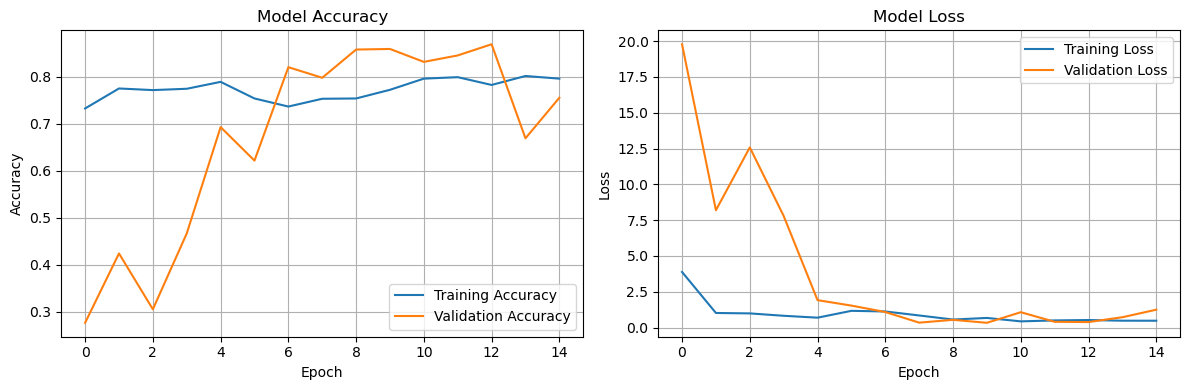


Executing Cell 5: Grad-CAM Visualization
Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 

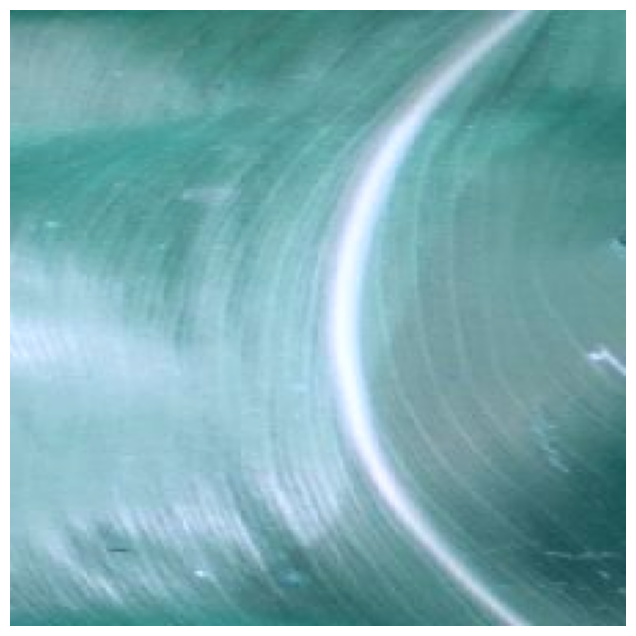


Executing Cell 6: Genetic Algorithm Optimization
Starting genetic algorithm optimization...
Building model...
Training model...
Epoch 1/10
100/100 [==============================] - 37s 360ms/step - loss: 17.2726 - accuracy: 0.7056 - val_loss: 3.7170 - val_accuracy: 0.4038
Epoch 2/10
100/100 [==============================] - 35s 354ms/step - loss: 1.5263 - accuracy: 0.7069 - val_loss: 1.6360 - val_accuracy: 0.3663
Epoch 3/10
100/100 [==============================] - 35s 353ms/step - loss: 8.1240 - accuracy: 0.6984 - val_loss: 9.3113 - val_accuracy: 0.5550
Epoch 4/10
100/100 [==============================] - 35s 354ms/step - loss: 4.7634 - accuracy: 0.7203 - val_loss: 3.2169 - val_accuracy: 0.6350
Epoch 5/10
100/100 [==============================] - 36s 364ms/step - loss: 5.6647 - accuracy: 0.7331 - val_loss: 1.0443 - val_accuracy: 0.7275
Epoch 6/10
100/100 [==============================] - 36s 356ms/step - loss: 2.0247 - accuracy: 0.7241 - val_loss: 2.5314 - val_accuracy: 0.5863


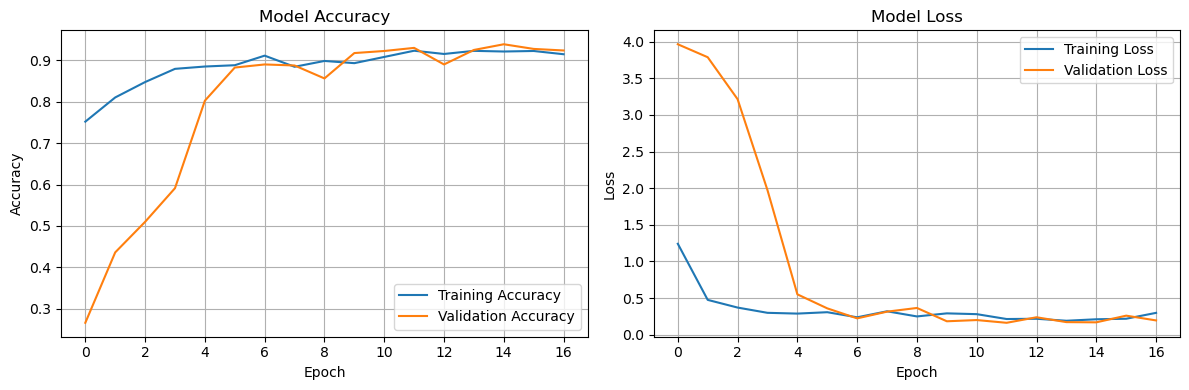

Testing final model...
Final Validation Loss: 0.1819
Final Validation Accuracy: 0.9350
25/25 [==============================] - 8s 326ms/step
Confusion matrix saved as 'confusion_matrix.png'


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import tensorflow as tf
from deap import base, creator, tools, algorithms
import random
import shutil

# Check for CUDA
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("CUDA GPU detected and configured")
else:
    print("No CUDA GPU detected, using CPU")

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Step 1: Balance Dataset
def balance_dataset(dataset_path, target_count=1000, save_path='balanced_corn_dataset'):
    print("Balancing dataset...")
    classes = [
        'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
        'Corn_(maize)___Common_rust_',
        'Corn_(maize)___Northern_Leaf_Blight',
        'Corn_(maize)___healthy'
    ]
    os.makedirs(save_path, exist_ok=True)
    
    # Data augmentation for classes with insufficient images
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        save_cls_path = os.path.join(save_path, cls)
        os.makedirs(save_cls_path, exist_ok=True)
        
        # Get list of images
        if not os.path.exists(cls_path):
            raise FileNotFoundError(f"Directory {cls_path} does not exist")
        images = [os.path.join(cls_path, img) for img in os.listdir(cls_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        num_images = len(images)
        print(f"Class {cls}: {num_images} images found")
        
        # Clear destination folder to avoid duplicates
        for f in os.listdir(save_cls_path):
            os.remove(os.path.join(save_cls_path, f))
        
        # Handle based on number of images
        if num_images >= target_count:
            # Select 1000 images randomly
            images_to_copy = random.sample(images, target_count)
            for img_path in images_to_copy:
                img_name = os.path.basename(img_path)
                shutil.copy2(img_path, os.path.join(save_cls_path, img_name))
        else:
            # Copy all existing images
            for img_path in images:
                img_name = os.path.basename(img_path)
                shutil.copy2(img_path, os.path.join(save_cls_path, img_name))
            
            # Augment to reach target_count
            print(f"Augmenting {cls} to reach {target_count} images...")
            num_to_generate = target_count - num_images
            selected_images = random.choices(images, k=num_to_generate)
            
            for i, img_path in enumerate(selected_images):
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Warning: Failed to load image {img_path}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.reshape((1,) + img.shape)
                
                # Generate augmented image
                for batch in datagen.flow(img, batch_size=1):
                    aug_img = batch[0].astype('uint8')
                    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(os.path.join(save_cls_path, f'aug_{cls}_{i}.jpg'), aug_img)
                    break
                
                if (i + 1) % 100 == 0:
                    print(f"Generated {i + 1} augmented images for {cls}")
        
        # Verify final count
        final_images = [f for f in os.listdir(save_cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        num_final = len(final_images)
        print(f"Class {cls}: Total {num_final} images after balancing")
        if num_final != target_count:
            raise ValueError(f"Failed to balance {cls}: Expected {target_count}, got {num_final}")

# Step 2: Prepare Data
def prepare_data(dataset_path='balanced_corn_dataset', img_size=(224, 224), test_size=0.2, batch_size=32):
    print("Preparing data...")
    # Define class names for mapping
    classes = [
        'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
        'Corn_(maize)___Common_rust_',
        'Corn_(maize)___Northern_Leaf_Blight',
        'Corn_(maize)___healthy'
    ]
    
    # Data generators for training and validation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=test_size
    )
    
    # Training generator
    train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='training',
        shuffle=True,
        seed=42
    )
    
    # Validation generator
    val_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='sparse',
        subset='validation',
        shuffle=False,
        seed=42
    )
    
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    
    # Verify class distribution
    train_labels = train_generator.classes
    val_labels = val_generator.classes
    train_dist = np.bincount(train_labels)
    val_dist = np.bincount(val_labels)
    for i, cls in enumerate(classes):
        print(f"{cls} - Train: {train_dist[i]}, Val: {val_dist[i]}")
    
    return train_generator, val_generator, train_datagen

# Step 3: Build Model
def build_model(filters1=32, filters2=64, filters3=128, dense_units=128, dropout_rate=0.5, learning_rate=0.001):
    print("Building model...")
    model = Sequential([
        Conv2D(filters1, (3, 3), activation='relu', input_shape=(224, 224, 3), name='conv2d'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(filters2, (3, 3), activation='relu', name='conv2d_1'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(filters3, (3, 3), activation='relu', name='conv2d_2'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Step 4: Train Model
def train_model(model, train_generator, val_generator, epochs=20):
    print("Training model...")
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping],
        verbose=1
    )
    
    print("Training completed!")
    return history

# Step 5: Plot Training Metrics
def plot_training_metrics(history):
    print("Plotting training metrics...")
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Step 6: Grad-CAM Visualization
def grad_cam(model, img_array, layer_name):
    print("Generating Grad-CAM visualization...")
    try:
        grad_model = tf.keras.models.Model(
            [model.inputs],
            [model.get_layer(layer_name).output, model.output]
        )
    except ValueError:
        raise ValueError(f"Layer {layer_name} not found in model. Check model.summary() for correct layer name.")
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, tf.argmax(predictions[0])]
    
    grads = tape.gradient(loss, conv_outputs)
    print(f"conv_outputs shape: {conv_outputs.shape}")
    print(f"grads shape: {grads.shape}")
    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    print(f"pooled_grads shape: {pooled_grads.shape}")
    
    conv_outputs = conv_outputs[0]
    pooled_grads = pooled_grads[..., tf.newaxis]
    heatmap = tf.matmul(conv_outputs, pooled_grads)
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap + 1e-10)  # Avoid division by zero
    
    return heatmap.numpy()

def plot_grad_cam(img, heatmap, alpha=0.4):
    print("Plotting Grad-CAM...")
    img = img.astype(np.uint8)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Step 7: Genetic Algorithm Optimization
def optimize_model(train_generator, val_generator, generations=5):
    print("Starting genetic algorithm optimization...")
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    toolbox = base.Toolbox()
    
    # Define parameter ranges
    toolbox.register("filters1", random.randint, 16, 64)
    toolbox.register("filters2", random.randint, 32, 128)
    toolbox.register("filters3", random.randint, 64, 256)
    toolbox.register("dense_units", random.randint, 64, 256)
    toolbox.register("dropout_rate", random.uniform, 0.3, 0.7)
    toolbox.register("learning_rate", random.choice, [0.0001, 0.0005, 0.001, 0.005])
    
    toolbox.register("individual", tools.initCycle, creator.Individual,
                    (toolbox.filters1, toolbox.filters2, toolbox.filters3, toolbox.dense_units, toolbox.dropout_rate, toolbox.learning_rate), n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    def evaluate(individual):
        filters1, filters2, filters3, dense_units, dropout_rate, learning_rate = individual
        # Clamp dropout_rate to [0, 1]
        dropout_rate = max(0.0, min(1.0, dropout_rate))
        # Ensure integer values for filters and dense_units
        filters1 = int(max(16, min(64, filters1)))
        filters2 = int(max(32, min(128, filters2)))
        filters3 = int(max(64, min(256, filters3)))
        dense_units = int(max(64, min(256, dense_units)))
        # Ensure learning_rate is valid
        learning_rate = learning_rate if learning_rate in [0.0001, 0.0005, 0.001, 0.005] else 0.001
        model = build_model(filters1, filters2, filters3, dense_units, dropout_rate, learning_rate)
        history = train_model(model, train_generator, val_generator, epochs=10)
        val_acc = max(history.history['val_accuracy'])
        print(f"Individual {[filters1, filters2, filters3, dense_units, dropout_rate, learning_rate]}: Validation Accuracy = {val_acc}")
        return val_acc,
    
    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    
    # Custom mutation to respect bounds
    def custom_mutation(individual, indpb):
        if random.random() < indpb:
            individual[0] = random.randint(16, 64)  # filters1
        if random.random() < indpb:
            individual[1] = random.randint(32, 128)  # filters2
        if random.random() < indpb:
            individual[2] = random.randint(64, 256)  # filters3
        if random.random() < indpb:
            individual[3] = random.randint(64, 256)  # dense_units
        if random.random() < indpb:
            individual[4] = random.uniform(0.3, 0.7)  # dropout_rate
        if random.random() < indpb:
            individual[5] = random.choice([0.0001, 0.0005, 0.001, 0.005])  # learning_rate
        return individual,
    
    toolbox.register("mutate", custom_mutation, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    population = toolbox.population(n=10)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    
    pop, logbook = algorithms.eaSimple(population, toolbox,
                                     cxpb=0.5, mutpb=0.2,
                                     ngen=generations,
                                     stats=stats, verbose=True)
    
    best_ind = tools.selBest(pop, k=1)[0]
    print(f"Best individual: {best_ind}, Fitness: {best_ind.fitness.values[0]}")
    
    return best_ind

# Step 8: Test Final Model
def test_model(model, val_generator):
    print("Testing final model...")
    loss, accuracy = model.evaluate(val_generator, verbose=0)
    print(f"Final Validation Loss: {loss:.4f}")
    print(f"Final Validation Accuracy: {accuracy:.4f}")
    
    # Confusion Matrix
    val_generator.reset()
    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_generator.classes
    cm = tf.math.confusion_matrix(y_true, y_pred_classes)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix.png')
    plt.close()
    print("Confusion matrix saved as 'confusion_matrix.png'")

# Step 9: Load Single Image for Grad-CAM
def load_single_image(image_path, img_size=(224, 224)):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return img

# Main Execution
if __name__ == '__main__':
    dataset_path = r'C:\Users\ayush-m-cdd-rkk\Downloads\Corn_Dataset'
    
    # Cell 1: Balance dataset
    print("Executing Cell 1: Balance Dataset")
    balance_dataset(dataset_path)
    
    # Cell 2: Prepare data
    print("\nExecuting Cell 2: Prepare Data")
    train_generator, val_generator, train_datagen = prepare_data()
    
    # Cell 3: Build and train initial model
    print("\nExecuting Cell 3: Build and Train Initial Model")
    model = build_model()
    history = train_model(model, train_generator, val_generator)
    print("Saving model")
    model.save('model_cnn2.h5')
    
    # Cell 4: Plot training metrics
    print("\nExecuting Cell 4: Plot Training Metrics")
    plot_training_metrics(history)
    
    # Cell 5: Grad-CAM visualization
    print("\nExecuting Cell 5: Grad-CAM Visualization")
    # Load a single image for Grad-CAM
    sample_image_path = os.path.join(
        'balanced_corn_dataset',
        'Corn_(maize)___healthy',
        os.listdir('balanced_corn_dataset/Corn_(maize)___healthy')[0]
    )
    sample_img = load_single_image(sample_image_path)
    sample_img_array = np.expand_dims(sample_img, axis=0)
    print("Model summary:")
    model.summary()
    heatmap = grad_cam(model, sample_img_array, 'conv2d_2')
    plot_grad_cam(sample_img * 255, heatmap)
    
    # Cell 6: Optimize with genetic algorithm
    print("\nExecuting Cell 6: Genetic Algorithm Optimization")
    best_params = optimize_model(train_generator, val_generator)
    
    # Cell 7: Train and test final model
    print("\nExecuting Cell 7: Train and Test Final Model")
    final_model = build_model(
        filters1=int(best_params[0]),
        filters2=int(best_params[1]),
        filters3=int(best_params[2]),
        dense_units=int(best_params[3]),
        dropout_rate=best_params[4],
        learning_rate=best_params[5]
    )
    final_history = train_model(final_model, train_generator, val_generator)
    print("Saving final model")
    final_model.save('final_model_cnn2.h5')
    plot_training_metrics(final_history)
    test_model(final_model, val_generator)  

# Accuracy and Loss plots for Training and Validation of Final Model after Optimization

Plotting training metrics...


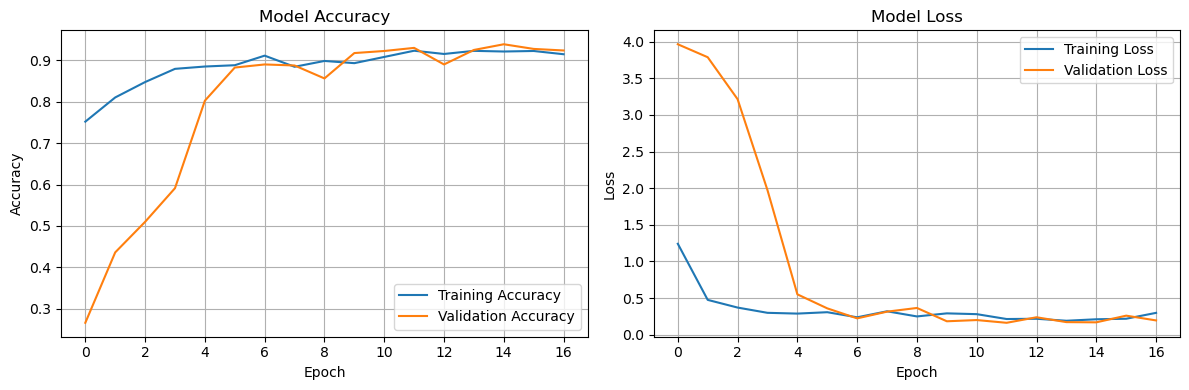

In [2]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_training_metrics_final(history):
    print("Plotting training metrics...")
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


plot_training_metrics_final(final_history)


# Final model parameters

In [3]:
print("Final Parameters of the model after optimization")
param_names = ['filters1', 'filters2', 'filters3', 'dense_units', 'dropout_rate', 'learning_rate']
for name, value in zip(param_names, best_params):
    print(f"{name}: {value}")


Final Parameters of the model after optimization
filters1: 33
filters2: 44
filters3: 217
dense_units: 203
dropout_rate: 0.4497730221449401
learning_rate: 0.0001


In [ ]:
final_model.save('final_model_cnn2.h5')  # Saves the model in HDF5 format

In [4]:
final_model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 33)      924       
                                                                 
 batch_normalization_114 (Ba  (None, 222, 222, 33)     132       
 tchNormalization)                                               
                                                                 
 max_pooling2d_114 (MaxPooli  (None, 111, 111, 33)     0         
 ng2D)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 44)      13112     
                                                                 
 batch_normalization_115 (Ba  (None, 109, 109, 44)     176       
 tchNormalization)                                               
                                                     

# Classification Report and Confusion Matrix


--- Final Optimized Model Evaluation ---
Evaluating model: sequential_38
25/25 [==============================] - 10s 386ms/step

Classification Report:
                 precision    recall  f1-score   support

     Cercospora       0.89      0.82      0.85       200
    Common_rust       0.99      0.99      0.99       200
Northern_Blight       0.83      0.90      0.87       200
        Healthy       1.00      1.00      1.00       200

       accuracy                           0.93       800
      macro avg       0.93      0.93      0.93       800
   weighted avg       0.93      0.93      0.93       800



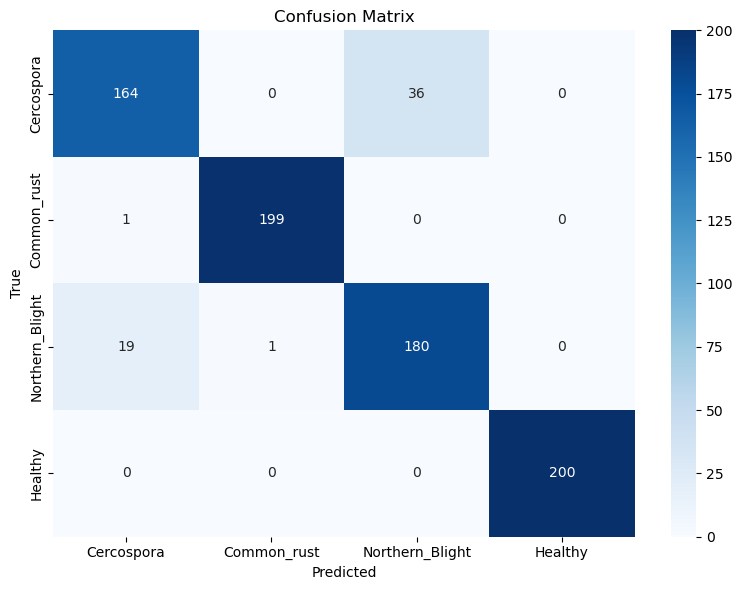

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Plot training vs. final accuracy and loss
def compare_histories(history1, history2, labels=("Initial", "Optimized")):
    print("Comparing model training histories...")

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['val_accuracy'], label=f'{labels[0]} Val Accuracy')
    plt.plot(history2.history['val_accuracy'], label=f'{labels[1]} Val Accuracy')
    plt.plot(history1.history['accuracy'], linestyle='--', label=f'{labels[0]} Train Accuracy')
    plt.plot(history2.history['accuracy'], linestyle='--', label=f'{labels[1]} Train Accuracy')
    plt.title('Validation vs Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['val_loss'], label=f'{labels[0]} Val Loss')
    plt.plot(history2.history['val_loss'], label=f'{labels[1]} Val Loss')
    plt.plot(history1.history['loss'], linestyle='--', label=f'{labels[0]} Train Loss')
    plt.plot(history2.history['loss'], linestyle='--', label=f'{labels[1]} Train Loss')
    plt.title('Validation vs Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("model_comparison.png")
    plt.show()
    print("Comparison plot saved as 'model_comparison.png'")

# Evaluate and print classification report
def evaluate_model(model, val_generator, label_names):
    print(f"Evaluating model: {model.name if hasattr(model, 'name') else 'Unnamed'}")
    val_generator.reset()
    y_pred = model.predict(val_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = val_generator.classes

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=label_names))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Class labels
class_names = [
    'Cercospora',
    'Common_rust',
    'Northern_Blight',
    'Healthy'
]

# # Evaluate both models
# print("\n--- Initial Model Evaluation ---")
# evaluate_model(model, val_generator, class_names)

print("\n--- Final Optimized Model Evaluation ---")
evaluate_model(final_model, val_generator, class_names)

# Compare training histories
# compare_histories(history, final_history)


# ROC Curve

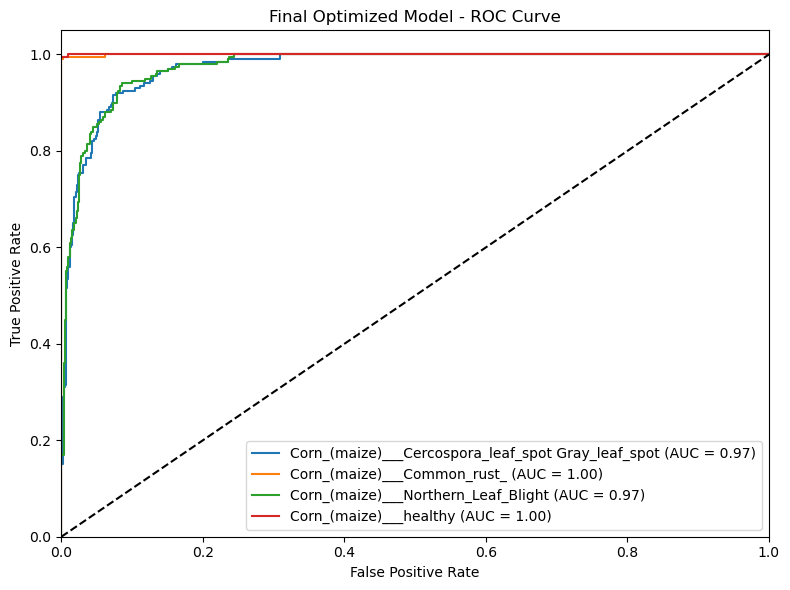

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, val_generator, model_name="Model"):
    y_true = val_generator.classes
    y_pred_probs = model.predict(val_generator, verbose=0)

    # Binarize the output
    class_labels = list(val_generator.class_indices.keys())
    y_true_bin = label_binarize(y_true, classes=range(len(class_labels)))

    plt.figure(figsize=(8, 6))
    for i in range(len(class_labels)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
plot_roc_curve(final_model, val_generator, model_name="Final Optimized Model")


# Per-Class Accuracy Comparison

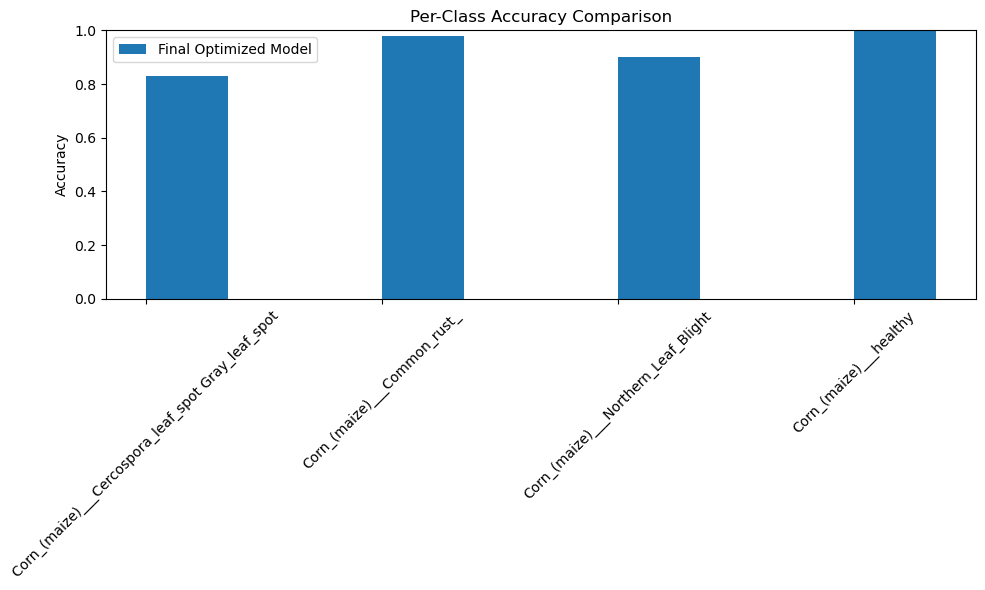

In [9]:
def per_class_accuracy(model, val_generator):
    y_pred_probs = model.predict(val_generator, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    acc_per_class = {}
    for i, label in enumerate(class_labels):
        idxs = np.where(y_true == i)[0]
        acc = np.mean(y_pred[idxs] == y_true[idxs])
        acc_per_class[label] = acc

    return acc_per_class

# Get accuracies
acc_initial = per_class_accuracy(model, val_generator)
acc_final = per_class_accuracy(final_model, val_generator)

# Bar plot
labels = list(acc_initial.keys())
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
# plt.bar(x - width/2, [acc_initial[l] for l in labels], width, label='Initial Model')
plt.bar(x + width/2, [acc_final[l] for l in labels], width, label='Final Optimized Model')
plt.xticks(x, labels, rotation=45)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy Comparison')
plt.legend()
plt.tight_layout()
plt.show()
acc_final = per_class_accuracy(final_model, val_generator)


# Actual vs Prediction

Evaluating final model on 10 random validation images...


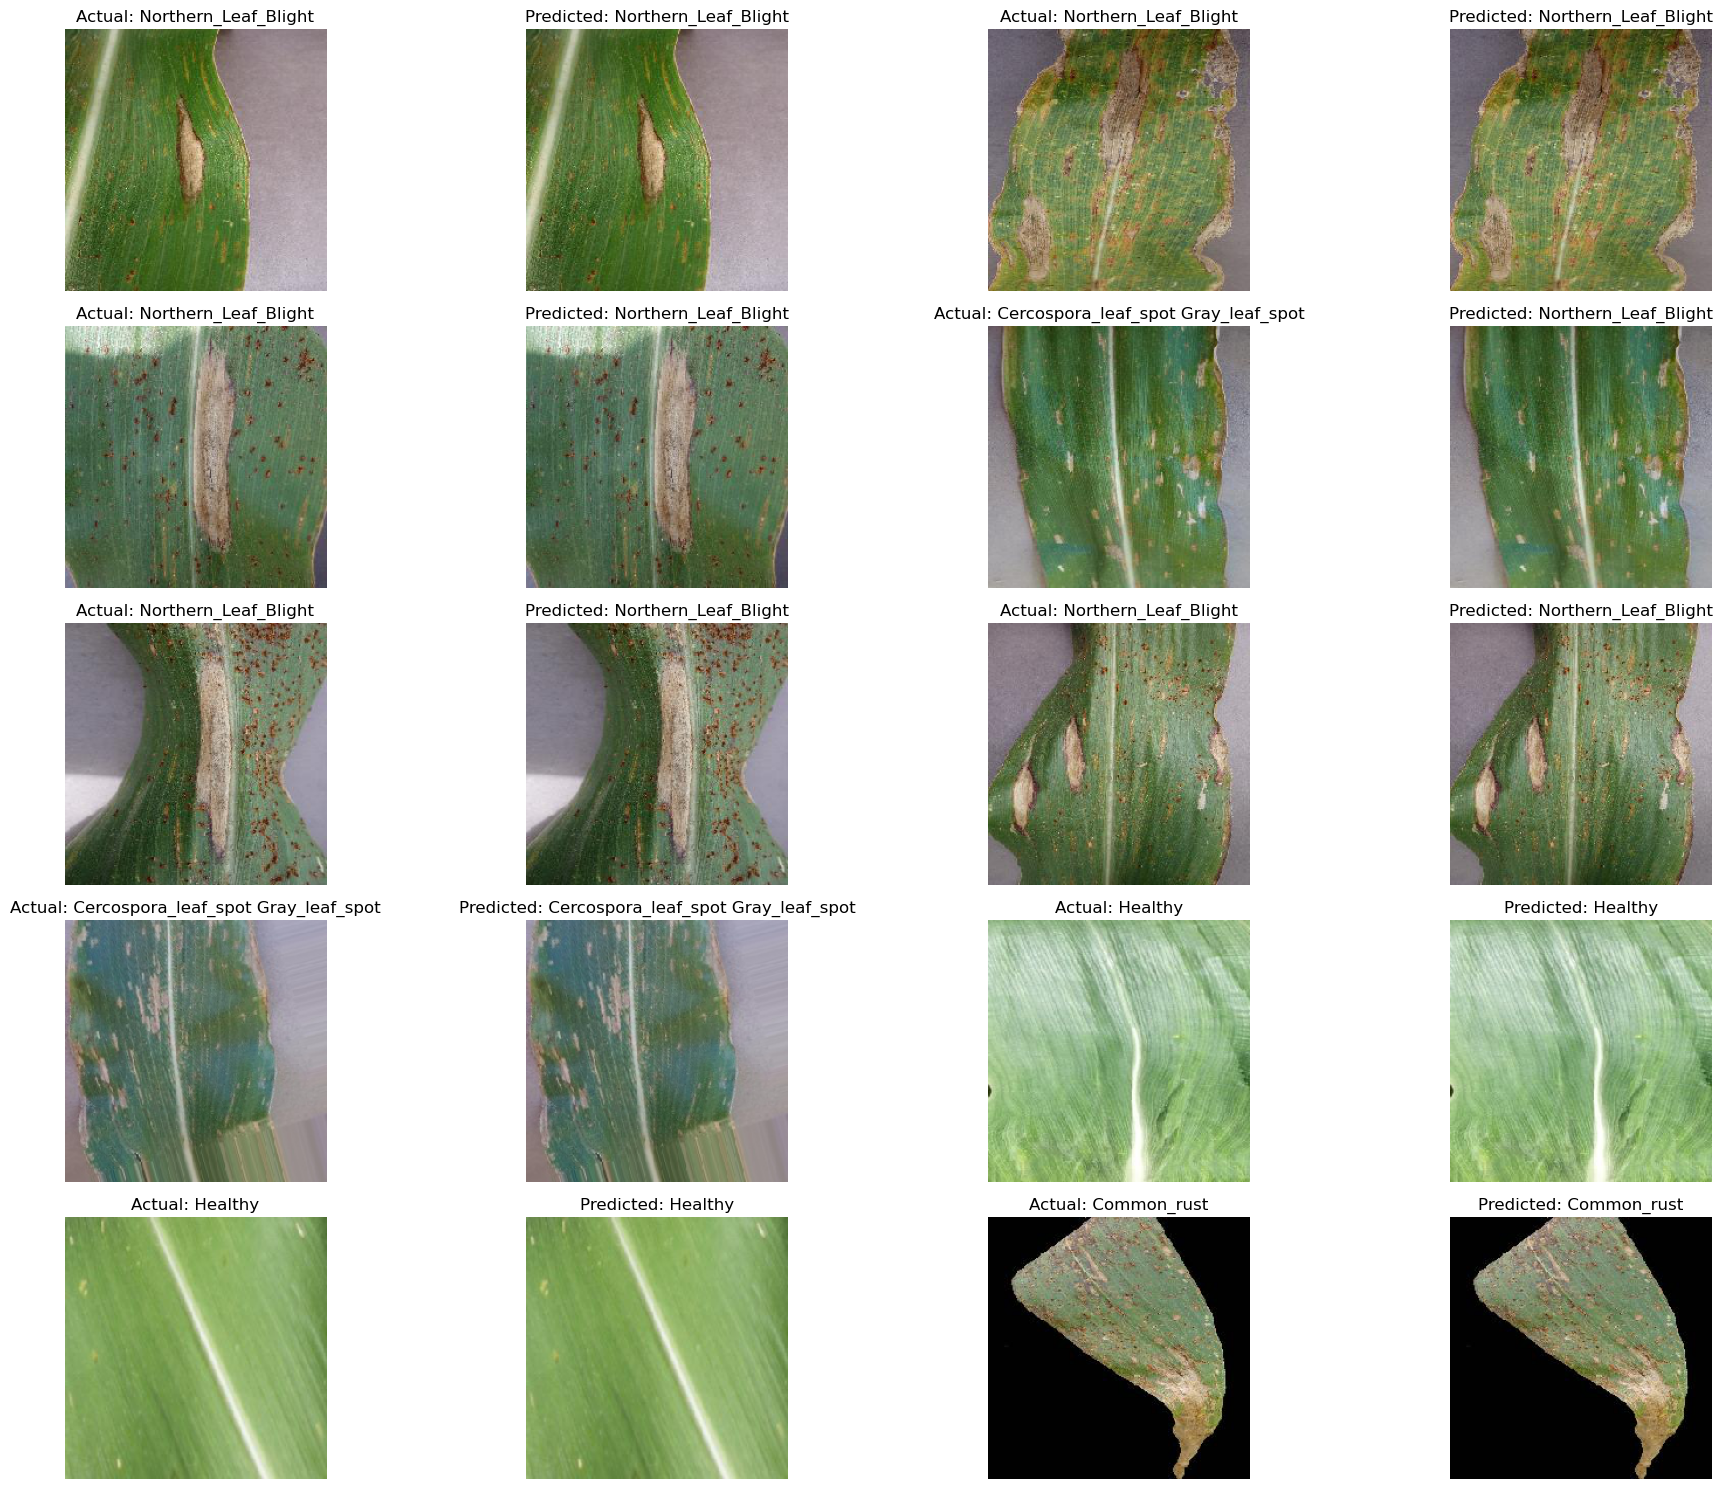

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to evaluate final_model on 10 random validation images
def evaluate_and_plot_predictions(model, val_generator, dataset_path='balanced_corn_dataset', img_size=(224, 224)):
    print("Evaluating final model on 10 random validation images...")
    
    # Class names
    class_names = [
        'Cercospora_leaf_spot Gray_leaf_spot',
        'Common_rust',
        'Northern_Leaf_Blight',
        'Healthy'
    ]
    
    # Get all validation image paths
    all_images = []
    all_labels = []
    for cls in val_generator.class_indices.keys():
        cls_path = os.path.join(dataset_path, cls)
        images = [os.path.join(cls_path, img) for img in os.listdir(cls_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        labels = [val_generator.class_indices[cls]] * len(images)
        all_images.extend(images)
        all_labels.extend(labels)
    
    # Select 10 random images
    indices = np.random.choice(len(all_images), 10, replace=False)
    selected_images = [all_images[i] for i in indices]
    selected_labels = [all_labels[i] for i in indices]
    
    # Prepare plot
    fig, axes = plt.subplots(5, 4, figsize=(20, 15))
    axes = axes.ravel()
    
    for i, (img_path, true_label) in enumerate(zip(selected_images, selected_labels)):
        # Load and preprocess image
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predict
        pred = model.predict(img_array, verbose=0)
        pred_label = np.argmax(pred, axis=1)[0]
        
        # Plot actual image
        axes[2*i].imshow(img)
        axes[2*i].set_title(f"Actual: {class_names[true_label]}")
        axes[2*i].axis('off')
        
        # Plot predicted image (same image with predicted label)
        axes[2*i + 1].imshow(img)
        axes[2*i + 1].set_title(f"Predicted: {class_names[pred_label]}")
        axes[2*i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Execute evaluation and plotting
evaluate_and_plot_predictions(final_model, val_generator)